# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

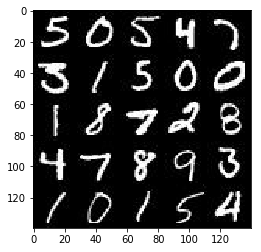

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

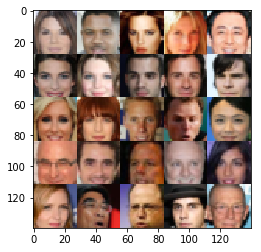

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real_ = tf.placeholder(tf.float32, 
                                shape = (None, image_width, image_height, image_channels), name = "input_real")
    input_z_ = tf.placeholder(tf.float32, shape = (None, z_dim), name = "input_z")
    learning_rate_ = tf.placeholder(tf.float32, name = "learning_rate")
    
    return input_real_, input_z_, learning_rate_


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # parameter for leaky relu
    alpha = 0.2
    # parameter for dropout layer
    keep_prob = 0.9

    #input images: 28 x 28 x out_channenl_dim (out_channel_dim = 1 or MNIST, 3 for CelebA)
    with tf.variable_scope('discriminator', reuse = reuse):
        
        # Input size: 28 x 28 x out_channel_dim (1 for MNIST, 3 for CelebA)
        x1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same')
        relu1 = tf.maximum(alpha * x1, x1)
        #print(relu1.shape)
        # current size: 14 x 14 x 64
        
        x2 = tf.nn.dropout(relu1, keep_prob = keep_prob)
        x2 = tf.layers.conv2d(x2, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        # current size: 7 x 7 x 128
        
        x3 = tf.nn.dropout(relu2, keep_prob = keep_prob)
        x3 = tf.layers.conv2d(x3, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        # current size: 4 x 4 x 256
        
        # flatten the layer and then connect to the ouput layer
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # parameter for leaky relu
    alpha = 0.2
    # parameter for dropout layer
    keep_prob = 0.9
    
    with tf.variable_scope('generator', reuse = not is_train):
        
        # input noise z to the connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape to 7 x 7 x 512 (since going to the convolution layer later)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(alpha * bn1, bn1)
        #print(relu1.shape)
        # current size: 7 x 7 x 512
        
        x2 = tf.nn.dropout(relu1, keep_prob = keep_prob)
        x2 = tf.layers.conv2d_transpose(x2, 256, 5, strides = 2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training = is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print(relu2.shape)
        # current size: 14 x 14 x 256

        x3 = tf.nn.dropout(relu2, keep_prob = keep_prob)
        x3 = tf.layers.conv2d_transpose(x3, 128, 5, strides = 2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training = is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
        #print(relu3.shape)
        # current size: 28 x 28 x 128
        
        # output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides = 1, padding='same')
        #print(logits.shape)
        # current size: 28 x 28 x out_channel_dim 
        
        out = tf.tanh(logits)
         
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)


Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # parameter for the smoothing
    smooth = 0.1
    
    # output/logits of the generator and discriminator
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    # evaluation of the loss
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_real,
                                        labels = tf.ones_like(d_logits_real)*(1.0 - smooth)))   
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                        labels = tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = d_logits_fake,
                                        labels = tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
    
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # set the out_channel_dim
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    else:
        print('incorrect input in data_image_mode')
    
    # check the consistency of data_image_mode and data_shape
    if(data_shape[3] != out_channel_dim):
        print('inconsistency in data_shape and data_image_mode')
    
    input_real, input_z, rl = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    # the variable used for refering the current status
    count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                count +=1

                # random noise for generator
                batch_z = np.random.uniform(-1, 1, size = (batch_size, z_dim))
                
                # note that for MNIST and CelebA, each entry in the data takes a value in the range [-0.5, 0.5].
                # normalization so that the value range becomes [-1, 1]
                batch_images = batch_images * 2

                # run optimizers
                _ = sess.run(d_train_opt, 
                             feed_dict={input_real: batch_images, input_z: batch_z, rl: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_z: batch_z, input_real: batch_images, rl: learning_rate})
                
                # display the current generator/discriminator
                if count%20 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                
                # display the images generated by the generator
                if count%100 == 0:
                    show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 20... Discriminator Loss: 0.3964... Generator Loss: 4.0400
Epoch 1/2... Batch 40... Discriminator Loss: 0.8085... Generator Loss: 1.4324
Epoch 1/2... Batch 60... Discriminator Loss: 0.4969... Generator Loss: 2.7071
Epoch 1/2... Batch 80... Discriminator Loss: 1.0448... Generator Loss: 0.8805
Epoch 1/2... Batch 100... Discriminator Loss: 0.7802... Generator Loss: 1.3972


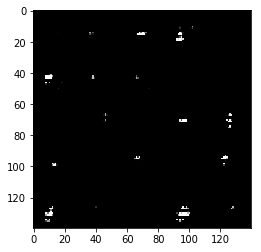

Epoch 1/2... Batch 120... Discriminator Loss: 0.9583... Generator Loss: 1.0384
Epoch 1/2... Batch 140... Discriminator Loss: 1.4866... Generator Loss: 0.6011
Epoch 1/2... Batch 160... Discriminator Loss: 1.6807... Generator Loss: 2.2624
Epoch 1/2... Batch 180... Discriminator Loss: 0.8191... Generator Loss: 1.6115
Epoch 1/2... Batch 200... Discriminator Loss: 0.7721... Generator Loss: 1.3608


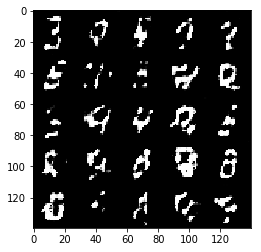

Epoch 1/2... Batch 220... Discriminator Loss: 0.7877... Generator Loss: 1.2111
Epoch 1/2... Batch 240... Discriminator Loss: 0.8149... Generator Loss: 1.1429
Epoch 1/2... Batch 260... Discriminator Loss: 0.9208... Generator Loss: 0.9495
Epoch 1/2... Batch 280... Discriminator Loss: 1.8865... Generator Loss: 4.0498
Epoch 1/2... Batch 300... Discriminator Loss: 1.4687... Generator Loss: 0.9881


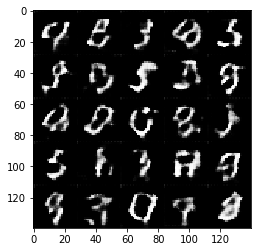

Epoch 1/2... Batch 320... Discriminator Loss: 1.3061... Generator Loss: 0.7958
Epoch 1/2... Batch 340... Discriminator Loss: 1.3158... Generator Loss: 0.9565
Epoch 1/2... Batch 360... Discriminator Loss: 1.1578... Generator Loss: 0.8016
Epoch 1/2... Batch 380... Discriminator Loss: 1.3076... Generator Loss: 0.7456
Epoch 1/2... Batch 400... Discriminator Loss: 1.1328... Generator Loss: 0.9872


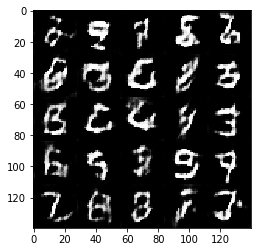

Epoch 1/2... Batch 420... Discriminator Loss: 1.2308... Generator Loss: 1.6044
Epoch 1/2... Batch 440... Discriminator Loss: 1.4992... Generator Loss: 0.4867
Epoch 1/2... Batch 460... Discriminator Loss: 1.0673... Generator Loss: 1.2770
Epoch 2/2... Batch 480... Discriminator Loss: 1.1258... Generator Loss: 0.9915
Epoch 2/2... Batch 500... Discriminator Loss: 1.1323... Generator Loss: 1.0445


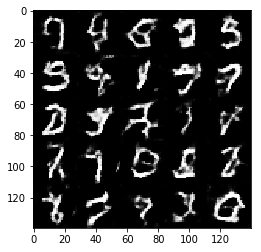

Epoch 2/2... Batch 520... Discriminator Loss: 1.2990... Generator Loss: 0.8276
Epoch 2/2... Batch 540... Discriminator Loss: 1.6103... Generator Loss: 0.4677
Epoch 2/2... Batch 560... Discriminator Loss: 1.0062... Generator Loss: 1.1232
Epoch 2/2... Batch 580... Discriminator Loss: 1.1106... Generator Loss: 1.0856
Epoch 2/2... Batch 600... Discriminator Loss: 1.2255... Generator Loss: 1.8385


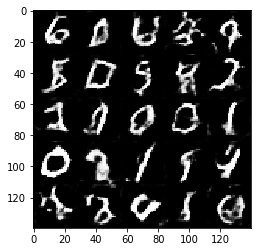

Epoch 2/2... Batch 620... Discriminator Loss: 1.1931... Generator Loss: 0.7835
Epoch 2/2... Batch 640... Discriminator Loss: 1.5128... Generator Loss: 2.0857
Epoch 2/2... Batch 660... Discriminator Loss: 1.0910... Generator Loss: 1.0732
Epoch 2/2... Batch 680... Discriminator Loss: 1.1863... Generator Loss: 0.7945
Epoch 2/2... Batch 700... Discriminator Loss: 1.2472... Generator Loss: 1.0068


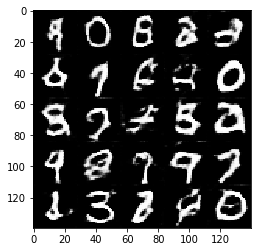

Epoch 2/2... Batch 720... Discriminator Loss: 1.4697... Generator Loss: 0.5394
Epoch 2/2... Batch 740... Discriminator Loss: 1.3493... Generator Loss: 0.5937
Epoch 2/2... Batch 760... Discriminator Loss: 1.4451... Generator Loss: 0.5588
Epoch 2/2... Batch 780... Discriminator Loss: 1.3010... Generator Loss: 2.0452
Epoch 2/2... Batch 800... Discriminator Loss: 1.1612... Generator Loss: 1.4088


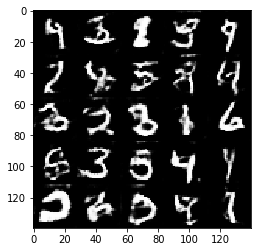

Epoch 2/2... Batch 820... Discriminator Loss: 1.2201... Generator Loss: 1.5303
Epoch 2/2... Batch 840... Discriminator Loss: 1.0356... Generator Loss: 0.9468
Epoch 2/2... Batch 860... Discriminator Loss: 1.3353... Generator Loss: 0.7255
Epoch 2/2... Batch 880... Discriminator Loss: 1.0243... Generator Loss: 1.1468
Epoch 2/2... Batch 900... Discriminator Loss: 1.2305... Generator Loss: 0.8307


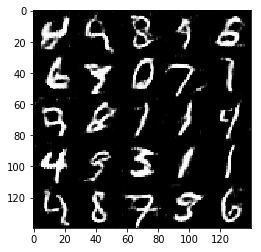

Epoch 2/2... Batch 920... Discriminator Loss: 1.0537... Generator Loss: 1.0380


In [30]:
batch_size = 128
z_dim = 64
learning_rate = 0.0025
beta1 = 0.50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 20... Discriminator Loss: 0.6613... Generator Loss: 2.7321
Epoch 1/1... Batch 40... Discriminator Loss: 5.2533... Generator Loss: 16.5466
Epoch 1/1... Batch 60... Discriminator Loss: 0.7810... Generator Loss: 2.6094
Epoch 1/1... Batch 80... Discriminator Loss: 0.6305... Generator Loss: 2.0860
Epoch 1/1... Batch 100... Discriminator Loss: 0.7204... Generator Loss: 2.6624


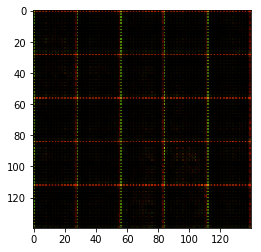

Epoch 1/1... Batch 120... Discriminator Loss: 0.4964... Generator Loss: 2.4423
Epoch 1/1... Batch 140... Discriminator Loss: 0.3722... Generator Loss: 5.9877
Epoch 1/1... Batch 160... Discriminator Loss: 0.4785... Generator Loss: 2.9891
Epoch 1/1... Batch 180... Discriminator Loss: 0.7248... Generator Loss: 1.7239
Epoch 1/1... Batch 200... Discriminator Loss: 1.5918... Generator Loss: 0.9069


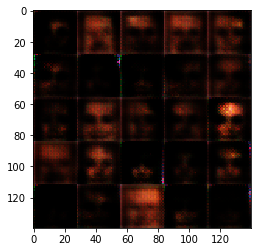

Epoch 1/1... Batch 220... Discriminator Loss: 1.4642... Generator Loss: 0.5433
Epoch 1/1... Batch 240... Discriminator Loss: 1.1813... Generator Loss: 1.2675
Epoch 1/1... Batch 260... Discriminator Loss: 0.5817... Generator Loss: 2.1268
Epoch 1/1... Batch 280... Discriminator Loss: 1.0267... Generator Loss: 1.2973
Epoch 1/1... Batch 300... Discriminator Loss: 1.3474... Generator Loss: 0.8819


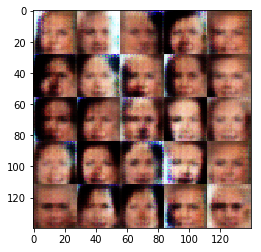

Epoch 1/1... Batch 320... Discriminator Loss: 1.4483... Generator Loss: 0.5477
Epoch 1/1... Batch 340... Discriminator Loss: 1.3129... Generator Loss: 1.9665
Epoch 1/1... Batch 360... Discriminator Loss: 0.9644... Generator Loss: 1.6102
Epoch 1/1... Batch 380... Discriminator Loss: 0.9139... Generator Loss: 1.2723
Epoch 1/1... Batch 400... Discriminator Loss: 1.4863... Generator Loss: 2.8539


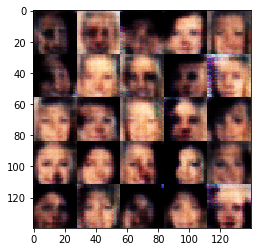

Epoch 1/1... Batch 420... Discriminator Loss: 1.2951... Generator Loss: 0.9109
Epoch 1/1... Batch 440... Discriminator Loss: 0.8176... Generator Loss: 2.1475
Epoch 1/1... Batch 460... Discriminator Loss: 1.0804... Generator Loss: 3.1411
Epoch 1/1... Batch 480... Discriminator Loss: 1.1450... Generator Loss: 0.9466
Epoch 1/1... Batch 500... Discriminator Loss: 0.8909... Generator Loss: 1.3327


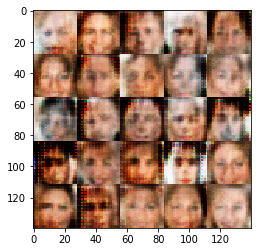

Epoch 1/1... Batch 520... Discriminator Loss: 1.0403... Generator Loss: 1.1525
Epoch 1/1... Batch 540... Discriminator Loss: 1.3330... Generator Loss: 0.5458
Epoch 1/1... Batch 560... Discriminator Loss: 1.1453... Generator Loss: 0.9303
Epoch 1/1... Batch 580... Discriminator Loss: 1.6463... Generator Loss: 0.3664
Epoch 1/1... Batch 600... Discriminator Loss: 1.0044... Generator Loss: 0.9268


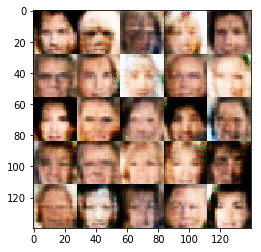

Epoch 1/1... Batch 620... Discriminator Loss: 1.1505... Generator Loss: 1.5247
Epoch 1/1... Batch 640... Discriminator Loss: 1.1843... Generator Loss: 0.8066
Epoch 1/1... Batch 660... Discriminator Loss: 1.3612... Generator Loss: 0.6566
Epoch 1/1... Batch 680... Discriminator Loss: 1.1131... Generator Loss: 0.9228
Epoch 1/1... Batch 700... Discriminator Loss: 1.3369... Generator Loss: 1.0397


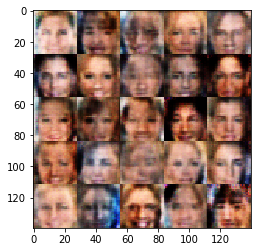

Epoch 1/1... Batch 720... Discriminator Loss: 1.2492... Generator Loss: 0.9576
Epoch 1/1... Batch 740... Discriminator Loss: 1.2326... Generator Loss: 0.7333
Epoch 1/1... Batch 760... Discriminator Loss: 1.3291... Generator Loss: 2.5222
Epoch 1/1... Batch 780... Discriminator Loss: 1.0658... Generator Loss: 0.8973
Epoch 1/1... Batch 800... Discriminator Loss: 1.3705... Generator Loss: 0.7870


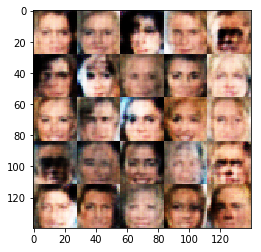

Epoch 1/1... Batch 820... Discriminator Loss: 0.9329... Generator Loss: 1.3316
Epoch 1/1... Batch 840... Discriminator Loss: 1.6419... Generator Loss: 1.0139
Epoch 1/1... Batch 860... Discriminator Loss: 0.8583... Generator Loss: 1.0797
Epoch 1/1... Batch 880... Discriminator Loss: 1.1677... Generator Loss: 0.7887
Epoch 1/1... Batch 900... Discriminator Loss: 1.2661... Generator Loss: 0.6146


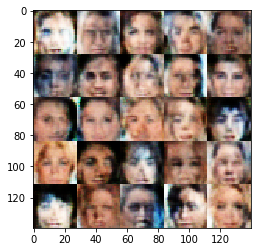

Epoch 1/1... Batch 920... Discriminator Loss: 1.4702... Generator Loss: 0.8179
Epoch 1/1... Batch 940... Discriminator Loss: 1.3586... Generator Loss: 1.5495
Epoch 1/1... Batch 960... Discriminator Loss: 1.5038... Generator Loss: 0.4987
Epoch 1/1... Batch 980... Discriminator Loss: 1.3131... Generator Loss: 1.8577
Epoch 1/1... Batch 1000... Discriminator Loss: 1.4079... Generator Loss: 0.8275


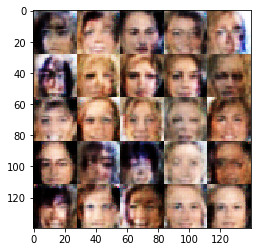

Epoch 1/1... Batch 1020... Discriminator Loss: 1.2513... Generator Loss: 1.0331
Epoch 1/1... Batch 1040... Discriminator Loss: 1.6186... Generator Loss: 0.4347
Epoch 1/1... Batch 1060... Discriminator Loss: 1.2318... Generator Loss: 0.9471
Epoch 1/1... Batch 1080... Discriminator Loss: 1.2085... Generator Loss: 0.9220
Epoch 1/1... Batch 1100... Discriminator Loss: 0.9645... Generator Loss: 1.2312


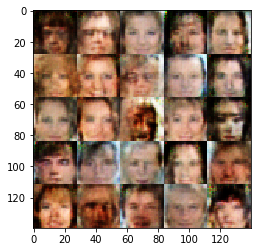

Epoch 1/1... Batch 1120... Discriminator Loss: 1.2529... Generator Loss: 1.2343
Epoch 1/1... Batch 1140... Discriminator Loss: 0.7703... Generator Loss: 1.3312
Epoch 1/1... Batch 1160... Discriminator Loss: 1.0430... Generator Loss: 1.1975
Epoch 1/1... Batch 1180... Discriminator Loss: 1.1585... Generator Loss: 0.7493
Epoch 1/1... Batch 1200... Discriminator Loss: 0.8573... Generator Loss: 1.4081


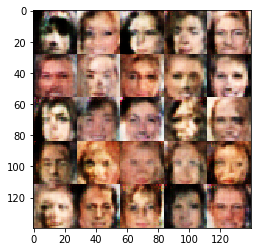

Epoch 1/1... Batch 1220... Discriminator Loss: 1.4869... Generator Loss: 0.6460
Epoch 1/1... Batch 1240... Discriminator Loss: 0.8938... Generator Loss: 1.4301
Epoch 1/1... Batch 1260... Discriminator Loss: 1.1883... Generator Loss: 0.6365
Epoch 1/1... Batch 1280... Discriminator Loss: 1.4002... Generator Loss: 1.8950
Epoch 1/1... Batch 1300... Discriminator Loss: 1.6229... Generator Loss: 1.6709


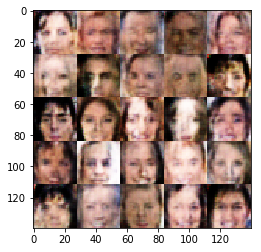

Epoch 1/1... Batch 1320... Discriminator Loss: 0.8467... Generator Loss: 1.8196
Epoch 1/1... Batch 1340... Discriminator Loss: 1.0626... Generator Loss: 0.9242
Epoch 1/1... Batch 1360... Discriminator Loss: 1.2396... Generator Loss: 1.4043
Epoch 1/1... Batch 1380... Discriminator Loss: 1.2090... Generator Loss: 0.7736
Epoch 1/1... Batch 1400... Discriminator Loss: 1.5710... Generator Loss: 0.4317


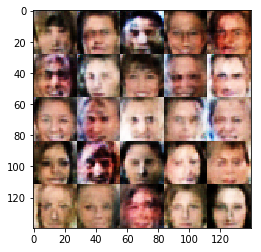

Epoch 1/1... Batch 1420... Discriminator Loss: 0.9974... Generator Loss: 1.0925
Epoch 1/1... Batch 1440... Discriminator Loss: 1.5461... Generator Loss: 1.4834
Epoch 1/1... Batch 1460... Discriminator Loss: 1.2312... Generator Loss: 1.3737
Epoch 1/1... Batch 1480... Discriminator Loss: 1.0232... Generator Loss: 1.1324
Epoch 1/1... Batch 1500... Discriminator Loss: 1.2977... Generator Loss: 0.8059


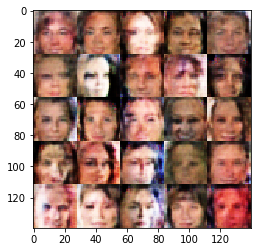

Epoch 1/1... Batch 1520... Discriminator Loss: 1.1364... Generator Loss: 1.1326
Epoch 1/1... Batch 1540... Discriminator Loss: 1.3240... Generator Loss: 0.6018
Epoch 1/1... Batch 1560... Discriminator Loss: 1.2983... Generator Loss: 0.9056
Epoch 1/1... Batch 1580... Discriminator Loss: 1.1928... Generator Loss: 0.6851
Epoch 1/1... Batch 1600... Discriminator Loss: 0.9001... Generator Loss: 1.6423


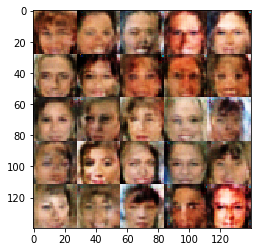

Epoch 1/1... Batch 1620... Discriminator Loss: 0.9887... Generator Loss: 1.0014
Epoch 1/1... Batch 1640... Discriminator Loss: 0.9573... Generator Loss: 1.5769
Epoch 1/1... Batch 1660... Discriminator Loss: 1.0747... Generator Loss: 1.0957
Epoch 1/1... Batch 1680... Discriminator Loss: 1.4957... Generator Loss: 0.4544
Epoch 1/1... Batch 1700... Discriminator Loss: 1.4210... Generator Loss: 0.9646


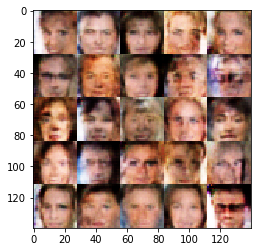

Epoch 1/1... Batch 1720... Discriminator Loss: 1.1062... Generator Loss: 1.0521
Epoch 1/1... Batch 1740... Discriminator Loss: 0.9705... Generator Loss: 1.3113
Epoch 1/1... Batch 1760... Discriminator Loss: 1.1202... Generator Loss: 0.8286
Epoch 1/1... Batch 1780... Discriminator Loss: 1.0929... Generator Loss: 0.8069
Epoch 1/1... Batch 1800... Discriminator Loss: 1.0484... Generator Loss: 0.9184


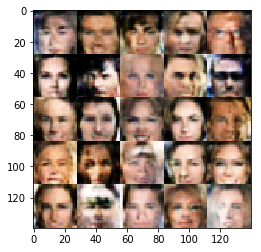

Epoch 1/1... Batch 1820... Discriminator Loss: 1.4792... Generator Loss: 0.6217
Epoch 1/1... Batch 1840... Discriminator Loss: 1.3779... Generator Loss: 0.6979
Epoch 1/1... Batch 1860... Discriminator Loss: 1.2712... Generator Loss: 0.8085
Epoch 1/1... Batch 1880... Discriminator Loss: 1.0563... Generator Loss: 0.8305
Epoch 1/1... Batch 1900... Discriminator Loss: 1.2422... Generator Loss: 0.7592


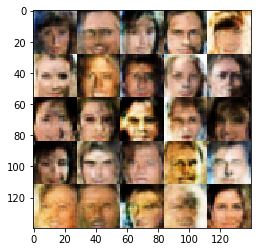

Epoch 1/1... Batch 1920... Discriminator Loss: 1.2856... Generator Loss: 1.1122
Epoch 1/1... Batch 1940... Discriminator Loss: 1.0658... Generator Loss: 1.0555
Epoch 1/1... Batch 1960... Discriminator Loss: 1.0453... Generator Loss: 1.4101
Epoch 1/1... Batch 1980... Discriminator Loss: 1.1185... Generator Loss: 0.7607
Epoch 1/1... Batch 2000... Discriminator Loss: 1.3382... Generator Loss: 1.3414


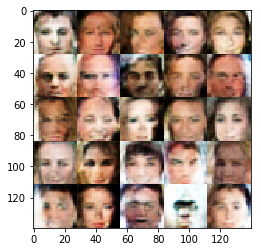

Epoch 1/1... Batch 2020... Discriminator Loss: 1.1392... Generator Loss: 0.8002
Epoch 1/1... Batch 2040... Discriminator Loss: 1.1821... Generator Loss: 1.0436
Epoch 1/1... Batch 2060... Discriminator Loss: 1.1536... Generator Loss: 1.2529
Epoch 1/1... Batch 2080... Discriminator Loss: 0.9547... Generator Loss: 1.4403
Epoch 1/1... Batch 2100... Discriminator Loss: 1.0715... Generator Loss: 0.7375


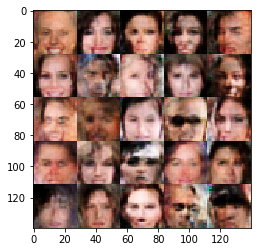

Epoch 1/1... Batch 2120... Discriminator Loss: 1.2928... Generator Loss: 0.6996
Epoch 1/1... Batch 2140... Discriminator Loss: 1.1040... Generator Loss: 1.0969
Epoch 1/1... Batch 2160... Discriminator Loss: 1.1571... Generator Loss: 0.9166
Epoch 1/1... Batch 2180... Discriminator Loss: 1.2832... Generator Loss: 0.9173
Epoch 1/1... Batch 2200... Discriminator Loss: 0.9357... Generator Loss: 1.2237


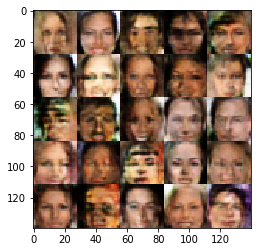

Epoch 1/1... Batch 2220... Discriminator Loss: 1.2420... Generator Loss: 1.1285
Epoch 1/1... Batch 2240... Discriminator Loss: 1.3782... Generator Loss: 1.2587
Epoch 1/1... Batch 2260... Discriminator Loss: 0.9951... Generator Loss: 1.1525
Epoch 1/1... Batch 2280... Discriminator Loss: 1.2596... Generator Loss: 0.6700
Epoch 1/1... Batch 2300... Discriminator Loss: 1.0853... Generator Loss: 0.8735


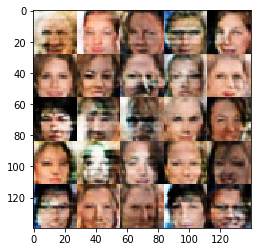

Epoch 1/1... Batch 2320... Discriminator Loss: 1.1511... Generator Loss: 0.7009
Epoch 1/1... Batch 2340... Discriminator Loss: 1.5125... Generator Loss: 0.4621
Epoch 1/1... Batch 2360... Discriminator Loss: 0.9983... Generator Loss: 1.0415
Epoch 1/1... Batch 2380... Discriminator Loss: 1.3208... Generator Loss: 1.3250
Epoch 1/1... Batch 2400... Discriminator Loss: 1.3561... Generator Loss: 0.7808


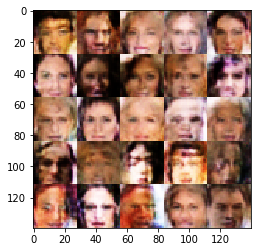

Epoch 1/1... Batch 2420... Discriminator Loss: 1.1201... Generator Loss: 0.8537
Epoch 1/1... Batch 2440... Discriminator Loss: 1.2724... Generator Loss: 0.9318
Epoch 1/1... Batch 2460... Discriminator Loss: 1.3210... Generator Loss: 0.6265
Epoch 1/1... Batch 2480... Discriminator Loss: 1.1554... Generator Loss: 0.9206
Epoch 1/1... Batch 2500... Discriminator Loss: 1.2378... Generator Loss: 0.6422


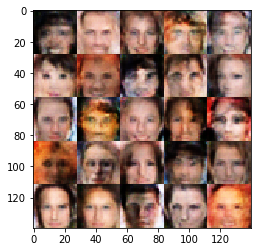

Epoch 1/1... Batch 2520... Discriminator Loss: 1.3499... Generator Loss: 0.6137
Epoch 1/1... Batch 2540... Discriminator Loss: 1.1610... Generator Loss: 0.6585
Epoch 1/1... Batch 2560... Discriminator Loss: 1.2179... Generator Loss: 0.8078
Epoch 1/1... Batch 2580... Discriminator Loss: 1.2416... Generator Loss: 0.7855
Epoch 1/1... Batch 2600... Discriminator Loss: 1.0231... Generator Loss: 1.0125


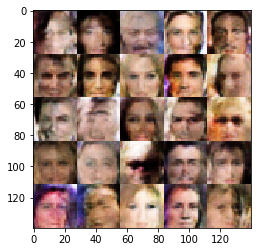

Epoch 1/1... Batch 2620... Discriminator Loss: 1.4655... Generator Loss: 0.5303
Epoch 1/1... Batch 2640... Discriminator Loss: 1.1078... Generator Loss: 1.0026
Epoch 1/1... Batch 2660... Discriminator Loss: 0.8924... Generator Loss: 1.4716
Epoch 1/1... Batch 2680... Discriminator Loss: 1.1314... Generator Loss: 0.8204
Epoch 1/1... Batch 2700... Discriminator Loss: 1.0450... Generator Loss: 1.1381


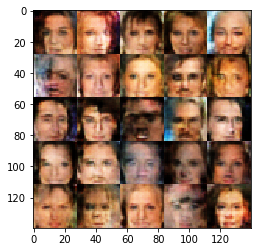

Epoch 1/1... Batch 2720... Discriminator Loss: 1.1325... Generator Loss: 0.8909
Epoch 1/1... Batch 2740... Discriminator Loss: 1.4560... Generator Loss: 0.7095
Epoch 1/1... Batch 2760... Discriminator Loss: 1.2357... Generator Loss: 0.9152
Epoch 1/1... Batch 2780... Discriminator Loss: 0.9548... Generator Loss: 1.0890
Epoch 1/1... Batch 2800... Discriminator Loss: 1.2951... Generator Loss: 0.7870


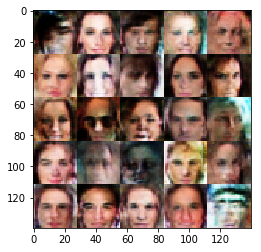

Epoch 1/1... Batch 2820... Discriminator Loss: 1.0808... Generator Loss: 0.9773
Epoch 1/1... Batch 2840... Discriminator Loss: 1.0853... Generator Loss: 1.2867
Epoch 1/1... Batch 2860... Discriminator Loss: 1.2106... Generator Loss: 1.1382
Epoch 1/1... Batch 2880... Discriminator Loss: 1.3302... Generator Loss: 1.1506
Epoch 1/1... Batch 2900... Discriminator Loss: 1.1550... Generator Loss: 0.8211


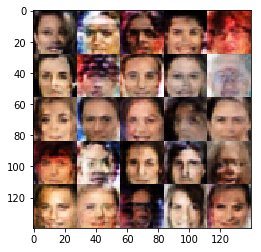

Epoch 1/1... Batch 2920... Discriminator Loss: 1.1653... Generator Loss: 0.7770
Epoch 1/1... Batch 2940... Discriminator Loss: 1.0794... Generator Loss: 1.1357
Epoch 1/1... Batch 2960... Discriminator Loss: 1.2155... Generator Loss: 0.6945
Epoch 1/1... Batch 2980... Discriminator Loss: 1.1796... Generator Loss: 1.1623
Epoch 1/1... Batch 3000... Discriminator Loss: 1.1483... Generator Loss: 0.7967


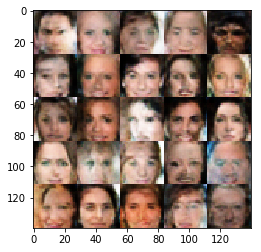

Epoch 1/1... Batch 3020... Discriminator Loss: 1.4266... Generator Loss: 0.4655
Epoch 1/1... Batch 3040... Discriminator Loss: 1.2713... Generator Loss: 0.6855
Epoch 1/1... Batch 3060... Discriminator Loss: 1.0941... Generator Loss: 0.8345
Epoch 1/1... Batch 3080... Discriminator Loss: 1.2159... Generator Loss: 0.7005
Epoch 1/1... Batch 3100... Discriminator Loss: 0.8797... Generator Loss: 2.0286


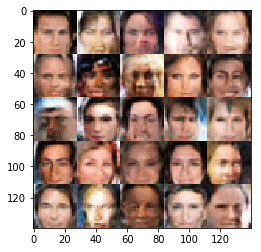

Epoch 1/1... Batch 3120... Discriminator Loss: 1.0469... Generator Loss: 1.0794
Epoch 1/1... Batch 3140... Discriminator Loss: 1.4571... Generator Loss: 0.6951
Epoch 1/1... Batch 3160... Discriminator Loss: 0.8691... Generator Loss: 1.7022


In [34]:
batch_size = 64
z_dim = 128
learning_rate = 0.0004
beta1 = 0.50

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.